This example takes you through the use of the
[GAIAmodel](/docs/API/kima/#kima.GAIAmodel) and
[RVGAIAmodel](/docs/API/kima/#kima.RVGAIAmodel) to analyse the Gaia epoch
astrometry and radial velocities from Gaia BH3 ([Gaia Collaboration et al.
2024](https://doi.org/10.1051/0004-6361/202449763)).

The example is divided into three parts: the first two using the `GAIAmodel` on
only the astrometric data, and the thrid including the radial velocities with
the `RVGAIAmodel`.

First lets import **kima** and the three examples

In [17]:
import kima
from kima.examples.GaiaBH3 import GAIA, GAIA_free, RVGAIA
from kima.examples.GaiaBH3 import Gaia_astrometry_BH3_datafile, Gaia_RVs_BH3_datafile

Let's load the model and check the reference epoch being used for the
astrometry: we use the reference epoch for Gaia DR4, 2457936.875, but notice
that we subtract 2400000 from the times (in the end this is just to make plots
more legible). 

In [18]:
model = GAIA_free(run=False)

In [19]:
model.data.M0_epoch

57936.875

The functions from the examples can be called with `run=True` to run the models
directly. But let's go through setting up the model in each case to explore the
available options.

The data class is still the same `GAIAdata` and we import the `GAIAmodel`. We
also import `RVData` and `RVGAIAmodel` since we will be using these later on,
and some distributions to set up the priors.

In [20]:
from kima import RVData, GAIAdata
from kima import GAIAmodel, RVGAIAmodel
from kima.distributions import (
    Uniform,
    Gaussian,
    ModifiedLogUniform,
    LogUniform,
    Kumaraswamy,
    Fixed,
)

## GAIAmodel with $Np$ free

Below is the setup for a model of the astrometric data with the number of Keplerians, $Np$, free
between 0 and 2. This is a very broad search for the BH3 signal, but given that the signal is so
large, it will probably be a bit inefficient. This is because nested sampling can struggle when the
prior is several times larger than the posterior, leading to inefficient sampling.

One way to *nudge* the sampler into the right direction is to fix the jitter to a high value (in
this case 0.5 mas), basically broadening the likelihood (and thus the posterior). If you're running
it yourself, try varying the jitter value to see if the model converges.

First, let's load the data from the file provided with the example, which looks like this

```
tcb	w	sigw	psi	pf
---	-	----	---	--
56958.110978	146.558250	0.031323	-1.030560	0.708280
56958.184993	146.136000	0.022889	-1.031674	0.708473
...
```

and can be loaded as 

In [22]:
data = GAIAdata(Gaia_astrometry_BH3_datafile, skip=2, units="mas")

We then set the epoch to the relevant Gaia reference time (here in TCB -
2400000), as mentioned before

In [23]:
data.M0_epoch =  57936.875 

Now we can create the model and set up the priors

In [26]:
model = GAIAmodel(fix=False, npmax=2, data=data)

For the first pass we are going to fix the jitter quite high, as explained above

In [30]:
model.Jprior = Fixed(0.5)  # in mas

We use broad priors for the period and semi-major axis, and default priors for
$\omega$, $\Omega$, and $\phi$

In [28]:
model.conditional.Pprior = LogUniform(100.0, 10000.0) # (1)
model.conditional.a0prior = ModifiedLogUniform(0.1, 100.0)
model.conditional.eprior = Kumaraswamy(0.867, 3.03)
model.conditional.cosiprior = Uniform(-1, 1)

For the priors for the 5-parameter astrometric solution, we use values from the
Gaia catalogue with appropriately wide priors to not bias the results

In [ ]:
model.da_prior = Gaussian(4.2,0.4)
model.dd_prior = Gaussian(2.4, 0.3)
model.mua_prior = Gaussian(-0.08, 0.2)
model.mud_prior = Gaussian(-0.42, 0.2)
model.parallax_prior = Uniform(1.3, 1.9)

And we also set the stellar mass, RA, and DEC. These are not needed for the
analysis but will be useful for handling of the posteriors and making plots

In [ ]:
model.star_mass = 1.2  # in solar masses
model.RA = 294.82796478104
model.DEC = 14.931669719919999

<div class="admonition note">
<div class="admonition-title">Note</div>
<p style="margin-top: 1em">
    We could also use a Thiele-Innes parametrisation instead of the (default) geometric 
    elements. In this case, we would not set priors for a0 or cosi.
</p>
<div class="highlight-ipynb hl-python">
<pre>
<span>model.conditional.thiele_innes <span class="o">=</span> <span class="kc">True</span></span>
<span>model.thiele_innes <span class="o">=</span> <span class="kc">True</span></span>
</pre>
</div>
</div>

In [31]:
kima.run(model, steps=100)

: 

Now run the model and load the results, the number of steps can be reduced to speed up at the cost of a less well explored posterior

In [ ]:
model, res = GAIA_free(run=True, load=True, steps=300000)

log(Z) = -76.58
Information = 51.03 nats
Effective sample size = 31306.4


Having loaded in the results, we can then plot the posterior for the number of
planets, confirming that we detect one orbit, that of GAIA BH3

Np probability ratios:  [1.87079321]


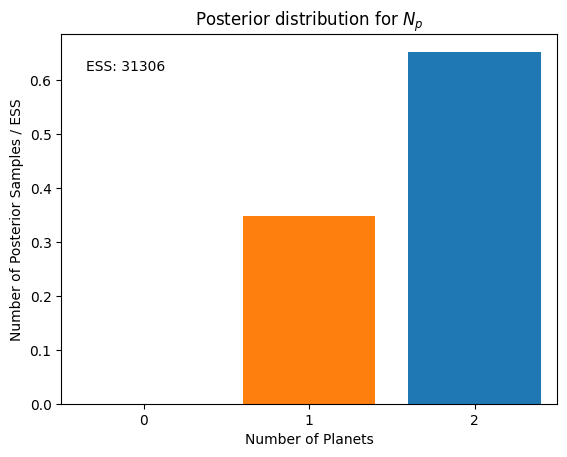

In [ ]:
res.plot_posterior_np()

We then obtain the maximum likelihood sample (with Np restricted to 1) this will print the parameters of this posterior sample.

In [7]:
p = res.maximum_likelihood_sample(Np=1)

Sample with the highest likelihood value  (logL = -18.34)
from samples with Np=1 only
-> might not be representative of the full posterior distribution

jitter:
  [0.5]
number of planets:  1
orbital parameters:           P         phi         ecc          a0           w        cosi           W 
                     3307.82306     5.80954     0.66031    22.24942     1.36509    -0.36689     2.35128


We now plot that astrometric phase plot, which shows the parallactic motion as well as the orbit of BH3 and the along-scan residuals. Notice that since we fixed the jitter to being high, the residuals, including the jitter, show that it clearly larger than necessary to fit the data. In the orbit plot, the x shows the centre-of-mass and the dashed line connects it to the pericentre.

Since we use tcb-2400000 as the time units, we have to specify this so that this plot can funciton properly

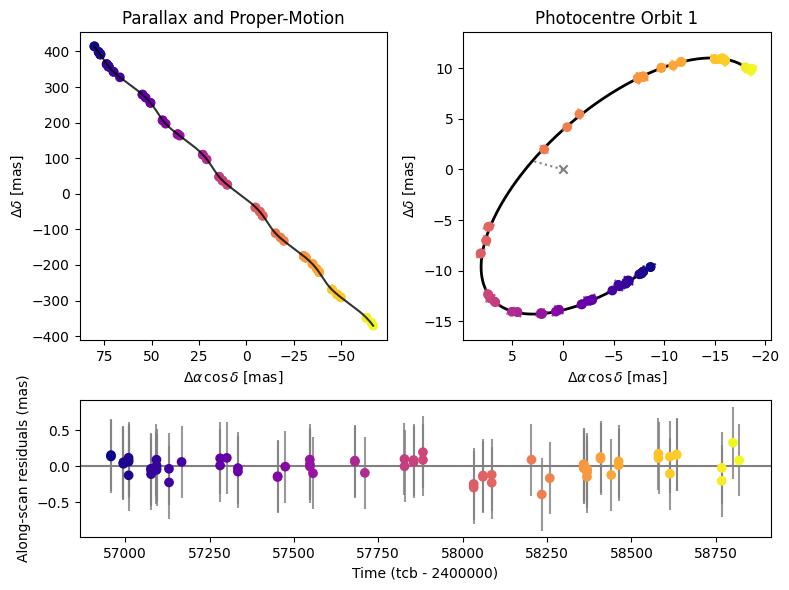

In [8]:
res.phase_plot(p,dates='tcb',date_sub=2400000,include_jitter=True);

We can also check the distribution of orbital periods within the posterior

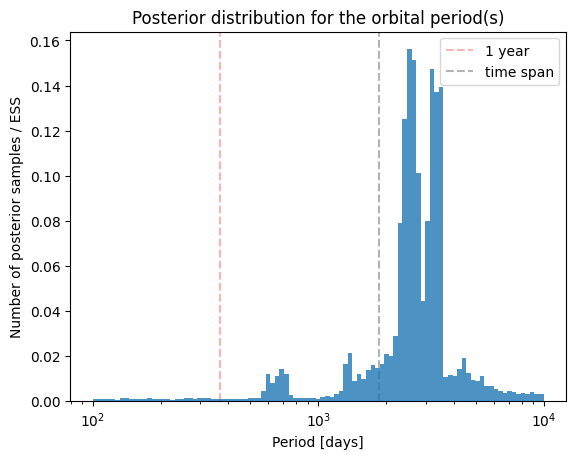

In [9]:
res.plot_posterior_periods();

## GAIAmodel with a known-object

We now set-up a run using the known-object mode, to give priors specifically for BH3, we chose priors wide enough to not bias the posterior constraints, but narrow enough that the sampling can be efficient. 

We then allow for additional Keplerians to be fit for up to a maximum number of N. This is then searching for additional periodicities in the data.

We now allow the jitter to be free rather than fixing to a specific value.

In [ ]:
def GAIA_example(run=False, load=False, **kwargs):
	# load the right data file, here is an example, though if running the example, you can also load the data directly from the example as above
	data = GAIAdata('Gaia_astrometry_BH3.gaia',skip=2,units='mas')
	data.M0_epoch =  57936.875 #Set the epoch to the relevant Gaia reference time (here in tcb - 2400000)
	# create the model
	model = GAIAmodel(fix=False, npmax=2, data=data)

	#We now let the Jitter be a free parameter
	model.Jprior = ModifiedLogUniform(0.01,0.5)

	#We could use the Thiele-Innes parametrisation, but instead chose to use the geometric elements. If Thiele-Innes used instead then priors cannot be set on a0 or cosi
	# model.conditional.thiele_innes = True
	# model.thiele_innes = True

	#Specify priors for the free search, here we let the priors on omega, Omega, and phi be default by not specifying them
	model.conditional.eprior = Kumaraswamy(0.867,3.03)
	model.conditional.Pprior = LogUniform(100.0,10000.0)
	model.conditional.a0prior = ModifiedLogUniform(0.1,100.0)
	model.conditional.cosiprior = Uniform(-1,1)

	#Specify the priors for the 5-parameter astrometric solution, the values can be taken from the Gaia catalogue with appropriately wide priors to not bias the results
	model.da_prior = Gaussian(4.2,0.4)
	model.dd_prior = Gaussian(2.4,0.3)
	model.mua_prior = Gaussian(-0.08,0.2)
	model.mud_prior = Gaussian(-0.42,0.2)
	model.parallax_prior = Uniform(1.3,1.9)

	#Specify the stars mass and RA and DEC, not needed for the analysis but can be useful for the handling of the posteriors and making plots
	model.star_mass = 1.2
	model.RA = 294.82796478104
	model.DEC = 14.931669719919999

	#We set the number of known objects to 1
	model.set_known_object(1)
	#We set the priors for the known-object mode, here there is 1 known object the black hole. We specify priors that will allow kima to sample efficiently, but not bias the results
	model.KO_Pprior = [Gaussian(4280,500)]
	model.KO_a0prior = [Gaussian(27.3,4.0)]
	model.KO_eprior = [Gaussian(0.73,0.04)]
	model.KO_omegaprior = [Gaussian(1.36,0.05)]
	model.KO_Omegaprior = [Gaussian(2.38,0.05)]
	model.KO_phiprior = [Uniform(0,2*np.pi)]
	model.KO_cosiprior = [Gaussian(-0.35,0.05)]

	#Set the sampler parameters (change steps to set length of the run, change threads depending on machine, others are reasonable to leave)
	kwargs.setdefault('steps', 5000)
	kwargs.setdefault('num_threads', 4)
	kwargs.setdefault('num_particles', 2)
	kwargs.setdefault('new_level_interval', 20000)
	kwargs.setdefault('save_interval', 2000) 


	if run:
		kima.run(model, **kwargs)
	if load:
		res = kima.load_results(model)
		return model, res
		
	return model

Now run the model and load the results, the number of steps can be reduced to speed up at the cost of a less well explored posterior

In [ ]:
model, res = GAIA(run=True, load=True, steps=100000)

log(Z) = 39.80
Information = 54.48 nats
Effective sample size = 11275.7


Plot the Np histogram, we find that a model with no additional Keplerians is favoured

Np probability ratios:  [1.45114638 1.05153136]


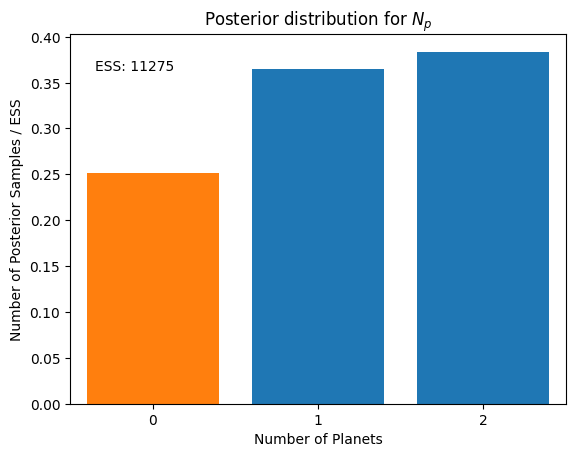

In [12]:
res.plot_posterior_np();

We can then take the maximum likelihood sample within Np=0 (recall the known-object is separate) and plot the astrometric phase-fold plot

In [13]:
p = res.maximum_likelihood_sample(Np=0)

Sample with the highest likelihood value  (logL = 100.82)
from samples with Np=0 only
-> might not be representative of the full posterior distribution

jitter:
  [0.06025959]
number of known objects:  1
orbital parameters:           P          a0         phi         ecc           w        cosi           W 
                     4256.85816    27.42283     5.92690     0.72918     1.36061    -0.35001
     2.37719


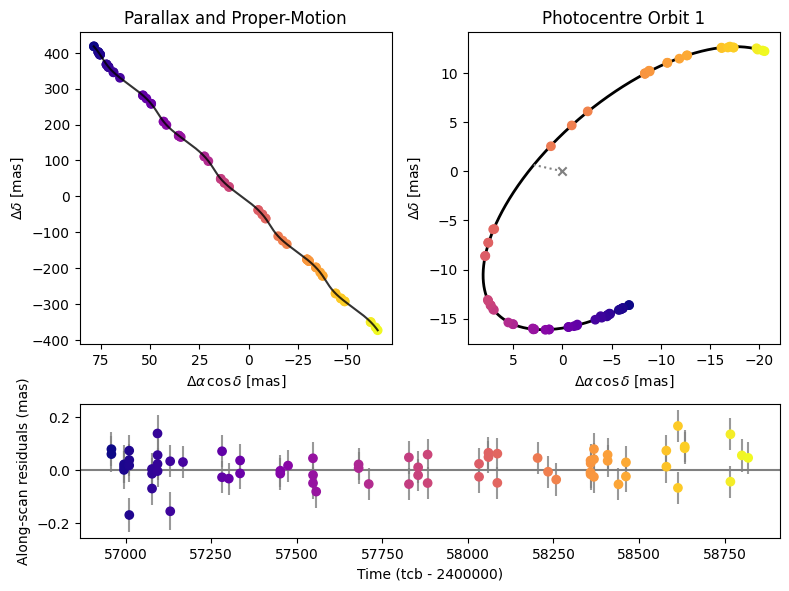

In [14]:
res.phase_plot(p,dates='tcb',date_sub=2400000,include_jitter=True);

Noticing that the uncertainties on the data look much better than when we had fixed the jitter, we can plot a histogram of the posterior constraint on the jitter

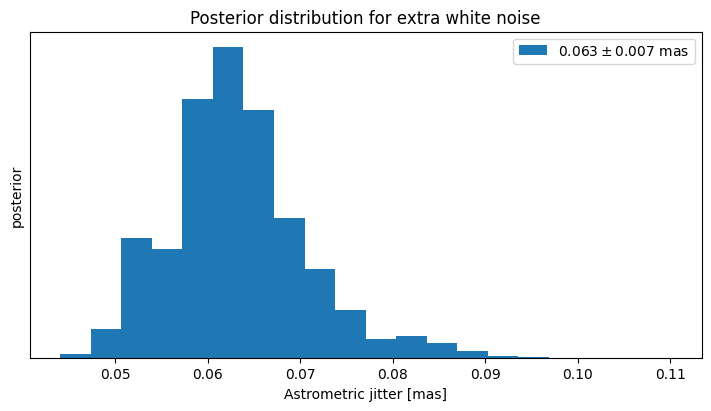

In [15]:
res.hist_jitter();

## The RVGAIA model

We can also use the radial velocity data (in this case from the Gaia RVS
instrument) in combination with the astrometric data to obtain better
constraints. We use the `RVGAIAmodel` which effectively combines the `GAIAmodel`
and the `RVmodel` classes for a joint analysis.

In [ ]:
def RVGAIA_example(run=False, load=False, **kwargs):
	#Load the right data files we now need to call an instance of GAIAdata to load in the astrometric data 
	#and one of RVData for the radial velocities. The reference epoch will be that of the astrometric data
	#we specify it explicitly.
	Gdata = GAIAdata('Gaia_astrometry_BH3.gaia',skip=2,units='mas')
	Vdata = RVData('Gaia_RVs_BH3.rdb',skip=2,units='kms')
	Gdata.M0_epoch =  57936.875
	# create the model giving both datatypes to the model
	model = RVGAIAmodel(fix=False, npmax=2, GAIAdata = Gdata, RVData=Vdata)

	#Set priors for systemic velocity and jitters for astrometry and RVs
	model.Cprior = Uniform(-400000,-300000)
	model.J_GAIA_prior = ModifiedLogUniform(0.01,0.2)
	model.J_RV_prior = ModifiedLogUniform(100.0,10000.0)

	#Set priors on planet parameters. Note that in the RVGAIAmodel we fit with a0 as the free parameter, and this is converted to K internally to calculate the RV Keplerian
	#here we let the priors on omega, Omega, and phi be default by not specifying them
	model.conditional.eprior = Kumaraswamy(0.867,3.03)
	model.conditional.Pprior = LogUniform(10.0,4000.0)
	model.conditional.a0prior = ModifiedLogUniform(0.01,2)
	model.conditional.cosiprior = Uniform(-1,1)

	#Specify the priors for the 5-parameter astrometric solution, the values can be taken from the Gaia catalogue with appropriately wide priors to not bias the results
	model.da_prior = Gaussian(4.2,0.4)
	model.dd_prior = Gaussian(2.4,0.3)
	model.mua_prior = Gaussian(-0.08,0.2)
	model.mud_prior = Gaussian(-0.42,0.2)
	model.parallax_prior = Uniform(1.3,1.9)

	#Specify the stars mass and RA and DEC, not needed for the analysis but can be useful for the handling of the posteriors and making plots
	model.star_mass = 1.2
	model.RA = 294.82796478104
	model.DEC = 14.931669719919999


	#We set the number of known objects to 1
	model.set_known_object(1)
	#We set the priors for the known-object mode, here there is 1 known object the black hole. We specify priors that will allow kima to sample efficiently, but not bias the results	
	model.KO_Pprior = [Gaussian(4280,500)]
	model.KO_a0prior = [Gaussian(27.3,4.0)]
	model.KO_eprior = [Gaussian(0.73,0.04)]
	model.KO_omegaprior = [Gaussian(1.36,0.05)]
	model.KO_Omegaprior = [Gaussian(2.38,0.05)]
	model.KO_phiprior = [Uniform(0,2*np.pi)]
	model.KO_cosiprior = [Gaussian(-0.35,0.05)]

	#Set the sampler parameters (change steps to set length of the run, change threads depending on machine, others are reasonable to leave)
	kwargs.setdefault('steps', 5000)
	kwargs.setdefault('num_threads', 4)
	kwargs.setdefault('num_particles', 2)
	kwargs.setdefault('new_level_interval', 20000)
	kwargs.setdefault('save_interval', 2000)


	if run:
		kima.run(model, **kwargs)
	if load:
		res = kima.load_results(model)
		return model, res
	return model

Now run the model and load the results, the number of steps can be reduced to speed up at the cost of a less well explored posterior

In [ ]:
model, res = RVGAIA(run=True, load=True, steps=100000)

log(Z) = -119.37
Information = 61.94 nats
Effective sample size = 2402.8


plot the Np histogram, again no extra Keplerian is detected

Np probability ratios:  [0.96239718 0.89377289]


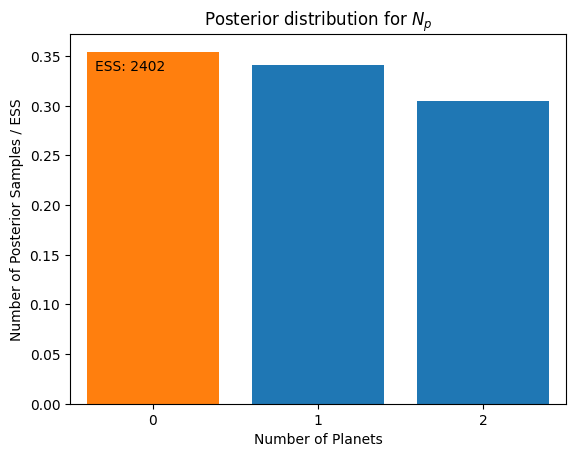

In [18]:
res.plot_posterior_np();

Obtain the maximium-likelihood Np=1 sample and plot the phase-fold panels. This time there is a separate plot for the radial velocity data and the astrometric data.

In [19]:
p = res.maximum_likelihood_sample(Np=0)

Sample with the highest likelihood value  (logL = -54.20)
from samples with Np=0 only
-> might not be representative of the full posterior distribution

jitter:
  [ 0.06746748 24.79930842]
number of known objects:  1
orbital parameters:           P          a0         phi         ecc           w        cosi           W 
                     4113.33714    26.75973     5.91093     0.72403     1.36778    -0.34939
     2.37563
vsys:  -356671.08518317


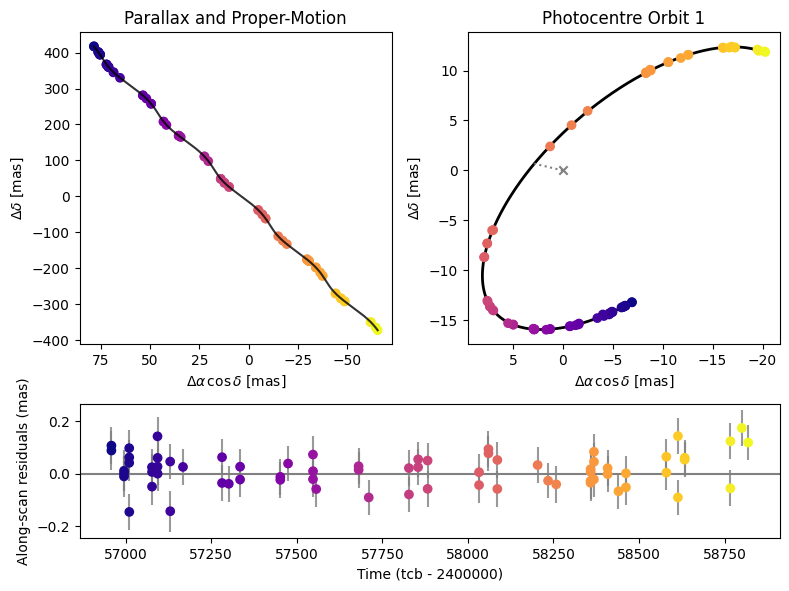

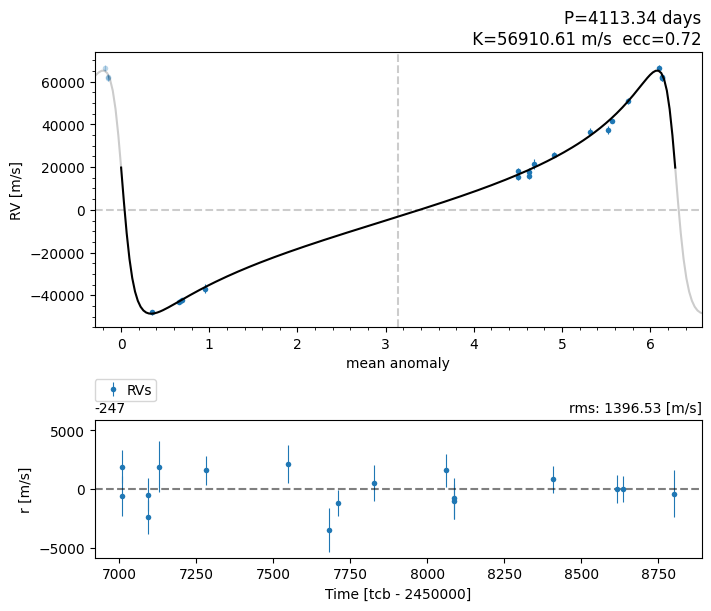

In [20]:
res.phase_plot(p,dates='tcb',date_sub=2400000,include_jitter=True);

We can plot the histograms for the Jitters, and vsys 

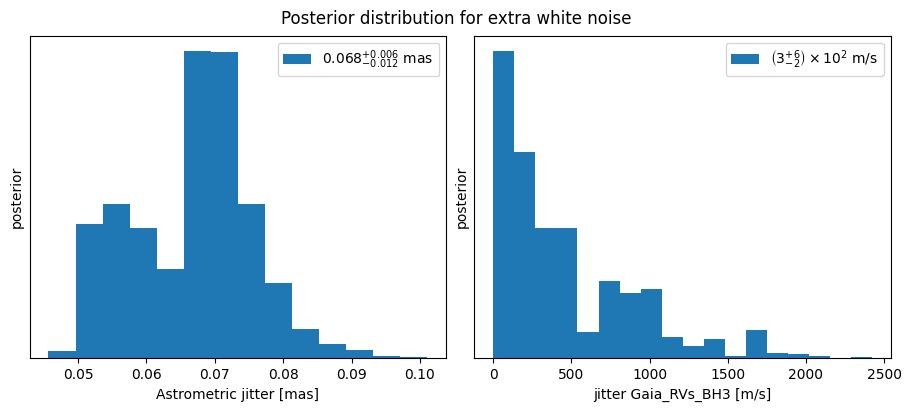

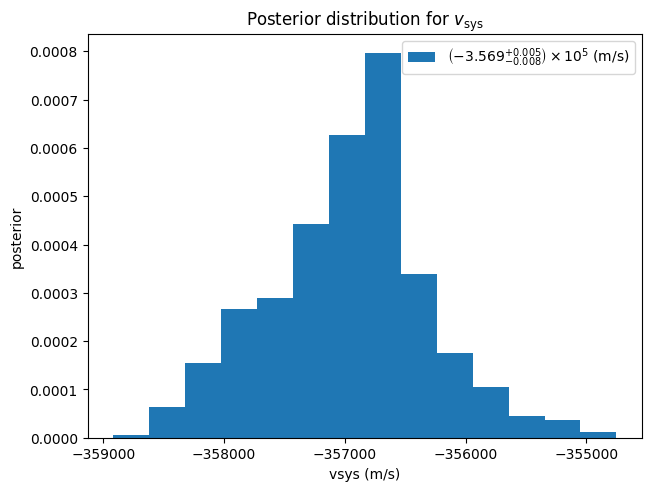

In [21]:
res.hist_jitter()
res.hist_vsys();

Let's plot the phase-fold for the maximum-likelihood Np=1 sample to see what the best possible other keplerian in this system would be. It is as expected simply a Keplerian within the noise.

Sample with the highest likelihood value  (logL = -42.12)
from samples with Np=1 only
-> might not be representative of the full posterior distribution

jitter:
  [5.19854100e-02 5.52090437e+02]
number of planets:  1
orbital parameters:           P         phi         ecc          a0           w        cosi           W 
                      312.22353     5.80310     0.34063     0.05131     1.65691    -0.32447     5.37371
number of known objects:  1
orbital parameters:           P          a0         phi         ecc           w        cosi           W 
                     4110.71207    26.78614     5.91143     0.72320     1.36653    -0.34954
     2.37538
vsys:  -356701.06819459


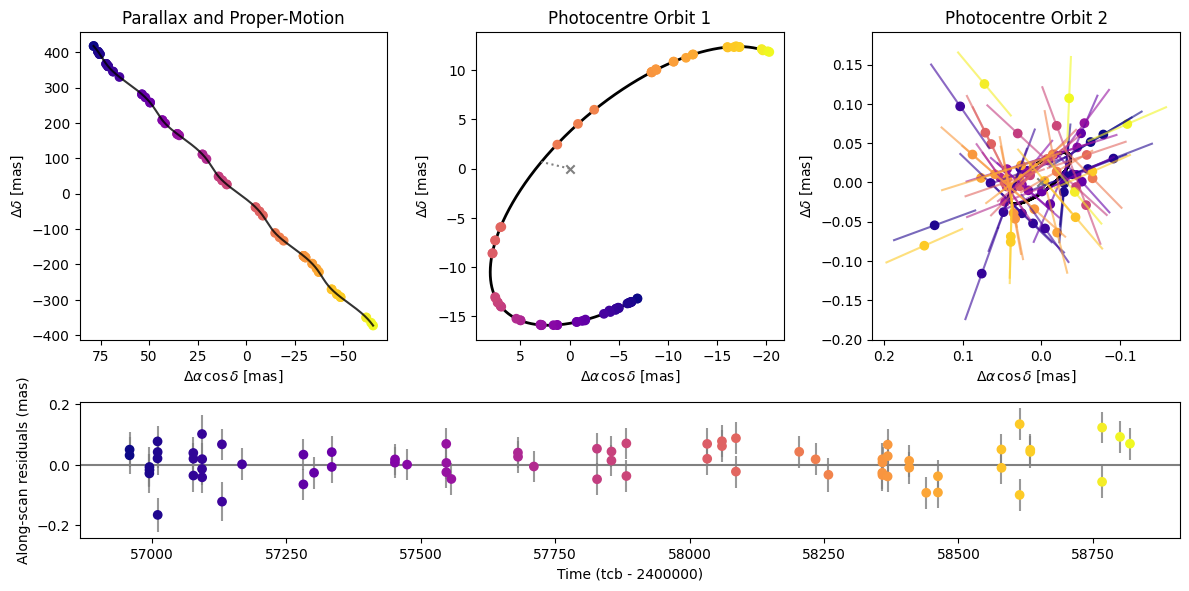

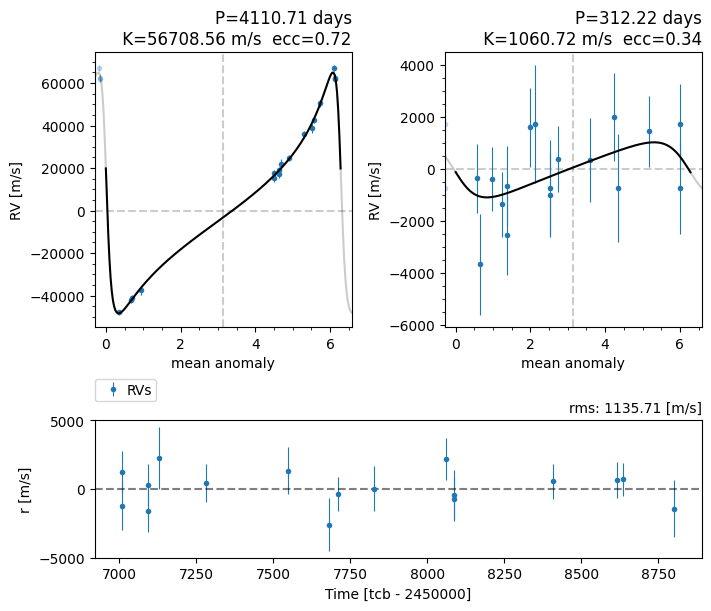

In [22]:
p = res.maximum_likelihood_sample(Np=1)
res.phase_plot(p,dates='tcb',date_sub=2400000,include_jitter=True);